# SNGuess Training Data Set

In this notebook we describe de procedure we followed in order to generate the training set for SNGuess. The objective of SNGuess is to predict in the early stages of a lightcurve whether it will be of interest for future follow up observations. It may also have other secondary objectives, such as predicting if a certain lightcurve will, in the end, be classified as belonging to a certain source object type.

In [1]:
import pandas as pd
import numpy as np
import re
from astropy.time import Time
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

## Light curve data

As an introduction, here is a plot showing the light curve with observations performed by ZTF of transient with ID ZTF21abbyhvw. This is the sort of transient that we look to be able to detect before its peak time.

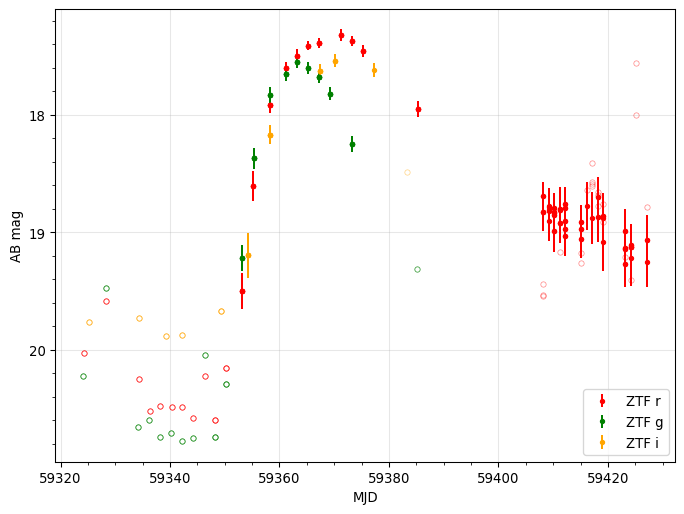

In [2]:
lc = pd.read_csv('ZTF21abbyhvw.csv')

my_dpi = 96.0
fig, ax = plt.subplots(figsize=(800/my_dpi, 600/my_dpi), dpi=my_dpi)
ztfr_mask = (lc['filter']=='ztfr') & (lc['mag'].notna())
ztfg_mask = (lc['filter']=='ztfg') & (lc['mag'].notna())
ztfi_mask = (lc['filter']=='ztfi') & (lc['mag'].notna())
ztfr_non_mask = (lc['filter']=='ztfr') & (lc['mag'].isna())
ztfg_non_mask = (lc['filter']=='ztfg') & (lc['mag'].isna())
ztfi_non_mask = (lc['filter']=='ztfi') & (lc['mag'].isna())
plt.errorbar(data=lc[ztfr_mask], x='mjd', y='mag', yerr='magerr',  c='r', fmt='.', label='ZTF r')
plt.errorbar(data=lc[ztfg_mask], x='mjd', y='mag', yerr='magerr',  c='g', fmt='.', label='ZTF g')
plt.errorbar(data=lc[ztfi_mask], x='mjd', y='mag', yerr='magerr',  c='orange', fmt='.', label='ZTF i')
plt.plot('mjd', 'limiting_mag', 'ro', data=lc[ztfr_non_mask], mfc='none', ms=4, mew=.5, alpha=0.5, label='')
plt.plot('mjd', 'limiting_mag', 'go', data=lc[ztfg_non_mask], mfc='none', ms=4, mew=.5, alpha=0.5, label='')
plt.plot('mjd', 'limiting_mag', 'o', data=lc[ztfi_non_mask], c='orange', mfc='none', ms=4, mew=.5, alpha=0.5, label='')
plt.gca().invert_yaxis()
plt.grid(alpha=0.3)
ax.yaxis.set_major_locator(ticker.MultipleLocator(base=1.0))
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.set_xlabel('MJD')
ax.set_ylabel('AB mag')
ax.legend(loc='lower right')
fig.savefig("ZTF21abbyhvw.pdf", bbox_inches='tight')

## Loading the input data files

First, we load the file `risedecline.csv`. This file contains a set of features, manually defined by a domain expert, and then calculated over a set of astronomical alerts, received and processed by the AMPEL broker system. Each row corresponds to features calculated from a single alert. A unique transient event (described by `snname`) thus frequently appear multiple times. `NaN` indicates a feature which could not be calculated based on the content of that specific alert. `RiseDecline` features calculated by the AMPEL T2 unit <https://github.com/AmpelProject/Ampel-contrib-HU/blob/master/ampel/contrib/hu/t2/T2RiseDeclineStat.py>.

In [3]:
features = pd.read_csv('risedecline.csv', index_col=0)
features

,cut_pp,jd_det,jd_last,ndet,mag_det,mag_last,t_lc,rb_med,drb_med,distnr_med,...,bool_rising,bool_hasgaps,slope_rise_g,slope_rise_r,col_det,col_last,col_peak,snname,slope_fall_g,slope_fall_r
0,0,2.458434e+06,2.458434e+06,1,17.577295,17.577295,0.000000,0.433333,NaN,1.078758,...,True,NaN,NaN,NaN,NaN,NaN,NaN,ZTF18aaxgaxw,NaN,NaN
1,0,2.458434e+06,2.458434e+06,1,17.577295,17.577295,0.000000,0.433333,NaN,1.078758,...,True,NaN,NaN,NaN,NaN,NaN,NaN,ZTF18aaxgaxw,NaN,NaN
2,0,2.458434e+06,2.458434e+06,1,17.577295,17.577295,0.000000,0.433333,NaN,1.078758,...,True,NaN,NaN,NaN,NaN,NaN,NaN,ZTF18aaxgaxw,NaN,NaN
3,0,2.458434e+06,2.458434e+06,1,17.577295,17.577295,0.000000,0.433333,NaN,1.078758,...,True,NaN,NaN,NaN,NaN,NaN,NaN,ZTF18aaxgaxw,NaN,NaN
4,0,2.458434e+06,2.458434e+06,1,17.577295,17.577295,0.000000,0.433333,NaN,1.078758,...,True,NaN,NaN,NaN,NaN,NaN,NaN,ZTF18aaxgaxw,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261412,0,2.458663e+06,2.458668e+06,2,17.056499,17.605425,4.979271,0.649286,0.214382,0.762824,...,False,False,NaN,NaN,NaN,NaN,NaN,ZTF19abddmnz,0.110242,NaN
261413,0,2.458668e+06,2.458671e+06,3,19.795700,19.604424,2.981759,0.897143,0.999895,1.378160,...,True,False,NaN,NaN,-0.069893,NaN,NaN,ZTF19abddoln,NaN,NaN
261414,0,2.458668e+06,2.458668e+06,2,19.795700,19.865593,0.020556,0.903571,0.999870,1.513054,...,True,False,NaN,NaN,-0.069893,-0.069893,NaN,ZTF19abddoln,NaN,NaN
261415,0,2.458668e+06,2.458674e+06,4,19.795700,19.511892,5.982535,0.903571,0.999920,1.470891,...,True,False,-0.047439,-0.088197,-0.069893,NaN,NaN,ZTF19abddoln,NaN,NaN


In [4]:
print("First detection:", Time(features.jd_last.min(), format='jd').iso)
print("Last detection:", Time(features.jd_last.max(), format='jd').iso)

First detection: 2018-05-04 05:18:33.002
Last detection: 2019-07-30 11:57:26.001


In [5]:
print("Number of alerts:", len(features))
print("Number of candidates:", len(features.snname.unique()))

Number of alerts: 261417
Number of candidates: 45765


The alerts sometimes contain nonsensical values. We set these consisently to `None`.

In [6]:
features.loc[features['distnr_med']<0, 'distnr_med'] = None
features.loc[features['magnr_med']<0, 'magnr_med'] = None
features.loc[features['sgscore1_med']<0, 'sgscore1_med'] = None
features.loc[features['distpsnr1_med']<0, 'distpsnr1_med'] = None
features.loc[features['sgscore2_med']<0, 'sgscore2_med'] = None
features.loc[features['distpsnr2_med']<0, 'distpsnr2_med'] = None
features.loc[features['neargaia_med']<0, 'neargaia_med'] = None
features.loc[features['maggaia_med']<0, 'maggaia_med'] = None

Also, there are very rare cases with duplicated photopoints. Possibly alerts issued multiple times. These are very rare. They are labeled with a `cut_pp` value of `True`. We proceed to remove these.

In [7]:
iDup = np.where(features["cut_pp"]>0)[0]
dupTransients = features.iloc[iDup]['snname'].unique()
features = features[ ~features['snname'].isin(dupTransients) ].copy()
features.reset_index(inplace=True)

In [8]:
print("Number of alerts:", len(features))
print("Number of candidates: %s"%(len(features.snname.unique())))

Number of alerts: 250325
Number of candidates: 45397


Then, we load a file that contains a catalog of candidate lightcurves from RCF, complete with their spectroscopical classification information. Note that this information is only used to assign classification labels - the photometric observation data in this file is not used. 

In [9]:
rcf_lc = pd.read_pickle('rcf_marshallc_sncosmo_200114.pkl')
print('Read %s RCF candidates.' % (len(rcf_lc)))

Read 4578 RCF candidates.


As the RCF scanning team consisently visually selects against likely CVs, we load a catalog of recent cataclysmic variable star lightcurves. Again, we will only make use of the IDs.

In [10]:
df_cv = pd.read_csv('CV_list_23Mar2020.txt', sep='\s+', skiprows=4, names=['name','ra','dec','l','b'])
rcf_cv = list(df_cv['name'])
print("Read %s CV candidates." % len(rcf_cv))

Read 495 CV candidates.


We also proceed to load a recently generated list of superluminous supernovae (SLSNe) that we can use to further update the classes of our dataset.

In [11]:
slsne = dict()
with open("list_of_superluminous_supernovae_slsne.txt") as fd:
    for line in fd:
        split_line = re.split(r'\s+', line)
        ztfid = split_line[0]
        subclass = split_line[9]
        slsne[ztfid] = subclass

## Adding RCF information into features table
We then proceed, by using the common ZTF identification string, to cross-match the data from our rise-decline feature data set with the classes of the RCF and the CV list datasets. We do this in order to complete our lightcurve feature table with columns indicating the class of the source object.

In [12]:
rcf_class = dict()
for tid, tdata in rcf_lc.items():
    rcf_class[tid] = tdata.meta['classification']
rcf_class = pd.Series(rcf_class, name='rcf_class')
features = features.merge(rcf_class, how='left', left_on='snname', right_index=True)

In [13]:
# Display ten most common type labels
features.rcf_class[features.rcf_class.notna()].value_counts()[:10]

SN Ia             16942
AGN                5573
SN II              5022
SN IIP             1790
SN IIn             1476
SN Ia 91T-like      854
SN Ic               813
SLSN-II             706
CV                  693
SN Ib               611
Name: rcf_class, dtype: int64

In [14]:
print("Number of valid types:", len(features.rcf_class[features.rcf_class.notna()].unique()))

Number of valid types: 79


We add the result of the cross matching as boolean columns to the feature table (one column for every class we are interested in)...

In [15]:
# SN types
sn_mask = features.rcf_class.fillna('').str.match(r"(SL)?SN", case=False)
gap_mask = features.rcf_class.fillna('').str.match(r"Gap", case=False)
slsne_mask = features.snname.isin(list(slsne.keys()))
features['rcf_sn'] = False
features.loc[(sn_mask | gap_mask | slsne_mask), 'rcf_sn'] = True

# AGN types
agn_mask = features.rcf_class.fillna('').str.match(r"AGN", case=False)
qso_mask = features.rcf_class.fillna('').str.match(r"QSO", case=False)
features['rcf_agn'] = False
features.loc[(agn_mask | qso_mask), 'rcf_agn'] = True

# CV types
cv_mask = features.rcf_class.fillna('').str.match(r"cv", case=False)
cv_rcf_mask = features.snname.isin(rcf_cv)
features['rcf_cv'] = False
features.loc[(cv_mask | cv_rcf_mask), 'rcf_cv'] = True

In [16]:
print("rcf_sn candidates:", features[features.rcf_sn].snname.unique().shape[0])
print("rcf_agn candidates:", features[features.rcf_agn].snname.unique().shape[0])
print("rcf_cv candidates:", features[features.rcf_cv].snname.unique().shape[0])

rcf_sn candidates: 1601
rcf_agn candidates: 174
rcf_cv candidates: 119


Finally, using our catalog of RCF lightcurves, we add a field that indicates whether the alert's source has been targeted by BTS

In [17]:
targeted_by_bts = pd.DataFrame(True, index=rcf_lc.keys(), columns=['targeted_by_bts'])
features = pd.merge(features, targeted_by_bts, how='left', left_on='snname', right_index=True)
features['targeted_by_bts'] = features['targeted_by_bts'].fillna(False)
print("%d candidates targeted by BTS." % (features[features.targeted_by_bts].snname.unique().shape[0]))
features.targeted_by_bts.value_counts()

2513 candidates targeted by BTS.


False    205536
True      44789
Name: targeted_by_bts, dtype: int64

## Adding sub-class information into features table

We can also add a new column called `subclass` that holds more detailed and fine-grained class information to our lightcurve data when available. We'll do that by using our RCF, SLSNe and paper updated class data sources.

In [18]:
# Add subclass data from slsne list
for ztfid, subclass in slsne.items():
    features.loc[features['snname'] == ztfid, 'subclass'] = subclass

We'll update some of the sub-classes of our samples with the corresponding reviewed information published in a 2018 paper by Fremling et al.

In [19]:
with open('rcf_2018paperchanges.txt') as f:
    paper_changes = [re.findall(r'^(\w+) :  (\S+) -> (\S+)',line)[0] for line in f]

# Add updated class data from paper
for ztfid, old_subclass, new_subclass in paper_changes:
    features.loc[features['snname'] == ztfid, 'subclass'] = "SN " + str(new_subclass)

We organize sub-classes in a hierarchy.

In [20]:
subclass_tree = {}
# test - classes that we first keep as a test sample, for possible confirmation later
# based on the result of this we might update the classification and rerun
subclass_tree['remove'] = ['Duplicate', 'bogus', 'duplicate',]
subclass_tree['to_test'] = ['AGN?' ,'AGN? ','Bogus?','CV Candidate', 'CV?', None, 'None',
                          'QSO?', 'blazar?','nan','nova?','old','star?', 'stellar?', 
                            'unclassified', 'unknown',]
subclass_tree['galaxy'] = ['AGN','CLAGN','LINER','LRN','NLS1','Q','QSO','Galaxy', 
                           'blazar','galaxy']
subclass_tree['sn'] = ['SN', 'SNIIb?', 'SLSN-I?', 'SN Ia?', 'SN Ib/c?', 'SN Ib?', 'SN Ic?', 
                       'SN?', 'SN? ', {} ]
subclass_tree['sn'][-1]['slsn'] = [ 'SLSN-I','SLSN-II', 'SLSN-R', 'SN SL-I']
subclass_tree['sn'][-1]['rare'] = ['Gap','Gap I', 'Gap I - Ca-rich','ILRT','LBV', 'TDE',]
subclass_tree['sn'][-1]['snii'] = ['SN II', 'SN IIL', 'SN IIP', 'SN IIb', 'SN IIn']
subclass_tree['sn'][-1]['snii_pec'] = ['SN II-87A', 'SN II-pec']
subclass_tree['sn'][-1]['snia'] = ['SNIa', 'SN Ia', 'SN Ia ', 'SN Ia 91T', 
                                   'SN Ia 91T-like', 'SN Ia-91T', 'SN Ia-norm']
subclass_tree['sn'][-1]['snia_pec'] = ['SN Ia 02cx-like', 'SN Ia 02ic-like', 'SN Ia 91bg-like', 
                                      'SN Ia-02cx', 'SN Ia-91bg', 'SN Ia-CSM', 'SN Ia-csm', 'SN Ia-pec','SN Iax']
subclass_tree['sn'][-1]['snibc'] = ['SN Ib','SN Ib/c','SN Ibn','SN Ic','SN Ic-BL',]

subclass_tree['stellar'] = ['CV','LRN','Nova', 'Var','star','varstar']

In [21]:
# Create a specific set of labels for easily distinguished sn subtypes:
# slsn, snii, snia, snibc
features.loc[:,'snclass'] = None
for subclass in ['slsn','snii','snia','snibc']:
    subnames = subclass_tree['sn'][-1][subclass]
    for subname in subnames:
        features.loc[features['subclass']==subname,'snclass'] = subclass

## Saving the final set

In [22]:
features.drop(columns='index').to_csv('snguess_training.csv', index_label=False)